In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [4]:
import numpy as np
import os 
from os import walk

def load_safari(folder):

    mypath = os.path.join("./mount/My Drive/Colab Notebooks/GDLgon/data", folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0
        
        x = x.reshape(x.shape[0], 28, 28, 1)
        
        y = [i] * len(x)  
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0: 
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1
        
    return xtotal, ytotal

In [5]:
import torch
import torch.nn as nn

class View(nn.Module):
    def __init__(self,shape):
        super().__init__()
        self.shape = shape,
    def forward(self,x):
        return x.view(*self.shape)

In [6]:
from torch.autograd import grad,Variable

class D(nn.Module):
    def __init__(self,dim_latent=200):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        self.dim_latent = dim_latent
       # 신경망 레이어 정의
        self.model = nn.Sequential(
            #(-1,1,28,28)
            nn.Conv2d(1, 64, kernel_size=7,stride=2,padding=3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,64,14,14)
            
            nn.Conv2d(64, 64, kernel_size=5, stride=2,padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,64,7,7)

            nn.Conv2d(64, 128, kernel_size=4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,128,4,4)
            
            nn.Conv2d(128, 128, kernel_size=3,padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,128,4,4)

            View((-1,128*4*4)),
            nn.Linear(128*4*4, 1),
        )


        # 손실 함수 생성
        
        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0008)
    def forward(self,x):
        return self.model(x)

    def wasserstein_loss(self,y_pred,y_true):
        return torch.mean(y_true*y_pred)

    def gradient_penalty_loss(self,x_batch,fake_img):
        batch_size = x_batch.shape[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(x_batch)
        
        #alpha = alpha.cuda()
        interpolated = alpha * x_batch.data + (1 - alpha) * fake_img.data
        interpolated = Variable(interpolated, requires_grad=True)        
        #interpolated=interpolated.cuda()
        y_pred = self.forward(interpolated)

        gradients = grad(outputs=y_pred, inputs=interpolated,
                               grad_outputs=torch.ones(y_pred.size()).cuda() if torch.cuda.is_available() else torch.ones(
                               y_pred.size()),
                               create_graph=True, retain_graph=True)[0]
        gradients = gradients.view(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        gp_loss = ((gradients_norm - 1) ** 2).mean()

        self.optimiser.zero_grad()
        gp_loss.backward()
        self.optimiser.step()
        return gp_loss

    def train(self,x_batch,label):
        self.optimiser.zero_grad()
        y_pred = self.forward(x_batch)

        

        loss = self.wasserstein_loss(y_pred,label)
        loss.backward()
        self.optimiser.step()
        return loss
        ## weight clipping하면 clipped grad 어떻게 계산되지?

In [7]:
class G(nn.Module):
    def __init__(self,dim_latent=100):
        # 파이토치 부모 클래스 초기화
        super().__init__()
       # 신경망 레이어 정의
        self.dim_latent = dim_latent
        self.model = nn.Sequential(
            #(-1,100)
            nn.Linear(self.dim_latent,64*7*7),
            View((-1,64,7,7)),
            #(-1,3136)
            #(-1,64,7,7)
            
            nn.ConvTranspose2d(64,64,4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),            
            #(-1,64,14,14)

            nn.ConvTranspose2d(64,128,5,padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,128,14,14)

            nn.ConvTranspose2d(128,64,6,stride=2,padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            #(-1,64,28,28)

            nn.ConvTranspose2d(64,1,5,padding=2),
            nn.Tanh(),
            #(-1,1,28,28)

        )


        # 옵티마이저 생성
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0004)
    def forward(self,x):
        return self.model(x)

    def train(self,D,latent_batch,label):
    
        self.optimiser.zero_grad()
        ## D.optimiser.zero_grad()  필요없음
        g_output = self.forward(latent_batch)
        d_output = D(g_output)

        loss = D.wasserstein_loss(d_output,label)
        loss.backward()
        self.optimiser.step()
        # D(x_input,1) ->D학습
        # D(G(latent), 0) ->D학습
        # D(G(latent),1) ->G학습
        return loss


In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

class MyDataset(Dataset):
    def __init__(self,foldername='camel'):
        (self.x_train, self.y_train) =load_safari(foldername)
    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        
        x_train = self.x_train.transpose((0,3,1,2))
        #return torch.FloatTensor(x_train[idx])
        return torch.cuda.FloatTensor(x_train[idx])
data_loader = DataLoader(MyDataset(), batch_size=64, shuffle=True,generator=torch.Generator(device='cuda'))
#data_loader = DataLoader(MyDataset(), batch_size=64, shuffle=True)


In [9]:
%%time 

d = D()
g= G()
d.to(device)
g.to(device)


d_loss_hist = []
g_loss_hist =[]
for epoch in range(1, 101):
    for i,x_input in enumerate(data_loader):

        pass
        label = torch.ones((x_input.shape[0],1))
        fake_label = -torch.ones((x_input.shape[0],1))
        d_loss=d.train(x_input,label)
        fake_img_batch = g(torch.randn(64,100)).detach()
        d_fake_loss=d.train(fake_img_batch,fake_label)
        gp_loss = d.gradient_penalty_loss(x_input,fake_img_batch)
        # gp_loss(fake_img_batch, x_input)
        ## interpolated_img = interpolate_img(fake_img_batch,x_input)
        ## d.optimizer.zero_grad()
        ## d.forward(interpolated_img)
        ## gradient 다 모으고
        ## L2_norm ==1 되도록 loss
        
        total_d_loss =(d_loss.item()+d_fake_loss.item()+gp_loss.item())/2
        d_loss_hist.append(total_d_loss)
        if (i%5==4):
            g_loss=g.train(d,torch.randn(64,100),label)
            g_loss_hist.append(g_loss.item())
        if i % 600 == 599:
            print(f"Epoch {epoch}: d_loss = {total_d_loss:.9f}  g loss={g_loss.item():.9f} gp loss={gp_loss.item():.9f}")


Epoch 1: d_loss = -4.626553059  g loss=-2.845868587 gp loss=5.127064705
Epoch 1: d_loss = -3.817706347  g loss=7.329447746 gp loss=3.152211189
Epoch 2: d_loss = -2.376920462  g loss=4.296702385 gp loss=2.387623787
Epoch 2: d_loss = -2.228862286  g loss=0.402261734 gp loss=2.386225700
Epoch 3: d_loss = -2.238299578  g loss=2.645200491 gp loss=2.521338224
Epoch 3: d_loss = -2.490603060  g loss=0.418016255 gp loss=2.359534264
Epoch 4: d_loss = -2.664510727  g loss=5.418620110 gp loss=2.592483044
Epoch 4: d_loss = -3.066860318  g loss=0.919521570 gp loss=2.576825619
Epoch 5: d_loss = -2.923700571  g loss=5.906776428 gp loss=2.281451702
Epoch 5: d_loss = -2.218498051  g loss=1.552146077 gp loss=2.170157909
Epoch 6: d_loss = -2.067625582  g loss=2.759704113 gp loss=2.448511124
Epoch 6: d_loss = -2.578875303  g loss=-0.569930315 gp loss=2.316027164
Epoch 7: d_loss = -1.719774842  g loss=-0.085452773 gp loss=1.646938324
Epoch 7: d_loss = -1.983355165  g loss=-0.578438640 gp loss=2.603035927
Ep

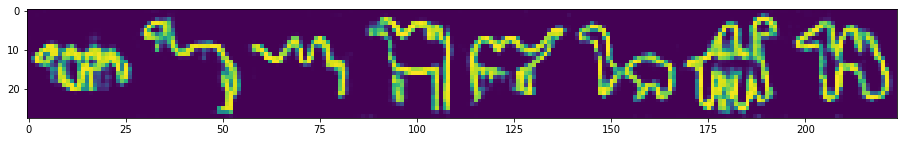

In [10]:
import matplotlib.pyplot as plt

fake_pred = g.forward(torch.randn(8,100)).detach().cpu().numpy() #(8,1,28,28)
fake_pred = fake_pred.transpose(0,2,3,1) #(8,28,28,1)
fake_8img = fake_pred.transpose(1,0,2,3).reshape(28,-1)
plt.figure(figsize=(16,2))
plt.imshow(fake_8img)

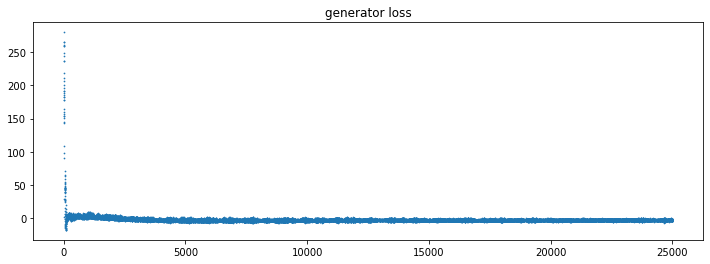

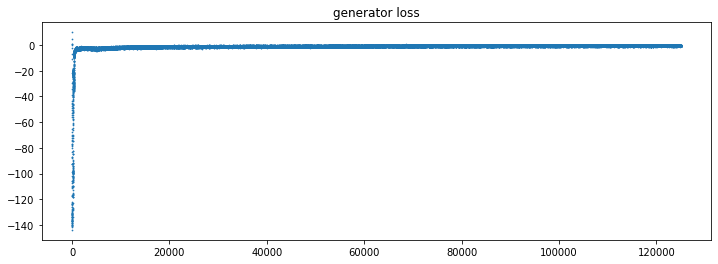

In [11]:
def visualize(loss_hist):
    plt.figure(figsize=(12,4))
    plt.scatter(np.arange(1,len(loss_hist)+1),loss_hist,s=0.5)
    plt.title('generator loss')
    plt.show()
visualize(g_loss_hist)
visualize(d_loss_hist)

In [12]:
torch.save(d.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_gp_d_camel_trained.pth")
torch.save(g.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_gp_g_camel_trained.pth")


In [ ]:
%%time 

d = D()
g= G()
d.load_state_dict(torch.load("./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_gp_d_camel_trained.pth"))
g.load_state_dict(torch.load("./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_gp_g_camel_trained.pth"))
d.to(device)
g.to(device)


d_loss_hist = []
g_loss_hist =[]
for epoch in range(1, 201):
    for i,x_input in enumerate(data_loader):

        pass
        label = torch.ones((x_input.shape[0],1))
        fake_label = torch.ones((x_input.shape[0],1))
        d_loss=d.train(x_input,label)
        fake_img_batch = g(torch.randn(64,100)).detach()
        d_fake_loss=d.train(fake_img_batch,fake_label)
        gp_loss = d.gradient_penalty_loss(x_input,fake_img_batch)
        # gp_loss(fake_img_batch, x_input)
        ## interpolated_img = interpolate_img(fake_img_batch,x_input)
        ## d.optimizer.zero_grad()
        ## d.forward(interpolated_img)
        ## gradient 다 모으고
        ## L2_norm ==1 되도록 loss
        
        total_d_loss =(d_loss.item()+d_fake_loss.item()+gp_loss.item())/2
        d_loss_hist.append(total_d_loss)
        if (i%5==4):
            g_loss=g.train(d,torch.randn(64,100),label)
            g_loss_hist.append(g_loss.item())
        if i % 600 == 599:
            print(f"Epoch {epoch}: d_loss = {total_d_loss:.9f}  g loss={g_loss.item():.9f} gp loss={gp_loss.item():.9f}")


Epoch 1: d_loss = -2253598556160.000000000  g loss=-2613407121408.000000000 gp loss=665720848384.000000000
Epoch 1: d_loss = -2325543654016.000000000  g loss=-2334769807360.000000000 gp loss=3573537536.000000000
Epoch 2: d_loss = -2537763040640.000000000  g loss=-2552839536640.000000000 gp loss=1330521344.000000000
Epoch 2: d_loss = 420464951296.000000000  g loss=-2323673513984.000000000 gp loss=5564521775104.000000000
Epoch 3: d_loss = -2623940304896.000000000  g loss=-2661792350208.000000000 gp loss=70072713216.000000000
Epoch 3: d_loss = -2604153260480.000000000  g loss=-2605515538432.000000000 gp loss=1840868480.000000000
Epoch 4: d_loss = -2552377744256.000000000  g loss=-2559359057920.000000000 gp loss=1130416384.000000000
Epoch 4: d_loss = -2645340517376.000000000  g loss=-2642961235968.000000000 gp loss=9678755840.000000000
Epoch 5: d_loss = -2714146560800.000000000  g loss=-2695670530048.000000000 gp loss=580667840.000000000
Epoch 5: d_loss = -2516859019264.000000000  g loss=-

KeyboardInterrupt: ignored

In [ ]:
torch.save(d.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_gp_d_camel_trained_epoch300.pth")
torch.save(g.state_dict(),"./mount/My Drive/Colab Notebooks/GDLgon/my_wgan_gp_g_camel_trained_epoch300.pth")

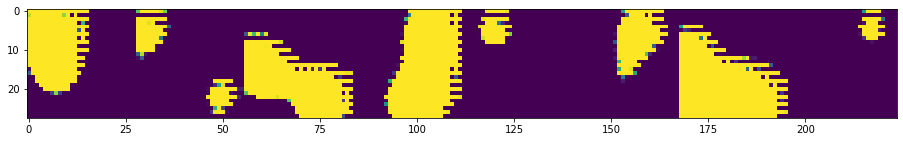

In [ ]:
import matplotlib.pyplot as plt

fake_pred = g.forward(torch.randn(8,100)).detach().cpu().numpy() #(8,1,28,28)
fake_pred = fake_pred.transpose(0,2,3,1) #(8,28,28,1)
fake_8img = fake_pred.transpose(1,0,2,3).reshape(28,-1)
plt.figure(figsize=(16,2))
plt.imshow(fake_8img)